# DeepTendies Example Notebook
## Hyper parameter optimization for tsla data

* Author: Mike Lasby
* Date: 2021-04-11
* Last Updated: 2021-04-11
* Reviewed by: N/A 

In [ ]:
%%bash
pip install -r https://raw.githubusercontent.com/deeptendies/deeptendies/master/requirements.txt && pip install git+https://github.com/deeptendies/deeptendies


# Data ingestion from API

In [ ]:
from deeptendies.stock_data import StockData
from deeptendies.trainer import Trainer
from deeptendies.model_metrics import ModelMetrics
# NOTE: Update stock name !
STOCK_NAME = 'TSLA'
closing_data = StockData(STOCK_NAME, days=7300, api_key="c1h8m1n48v6t9ghtpkh0")

Note: the following two cells is fo us to have the same appl data for generating the final report. **If you are using your own ticker, do not run the next 2 cells. just use the cell above**

In [ ]:
# TODO: final report only cell #1
# run this to connect gdrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Ingestion from static data store
This data is used for hyper parameter tuning or other experimentation using a common dataset

In [ ]:
# # TODO: final report only cell #2
# # run this to load team_data
# import pandas as pd
# # TODO: Please use this for getting final data to generate the final report
# tsla_finrep_data = "/content/drive/MyDrive/enel645-team-drive/Final-Project/tsla_7300.csv" # stock.df.to_csv(tsla_finrep_data)
# tsla_data_df = pd.read_csv(tsla_finrep_data, index_col=0)
# tsla_data_df['t'] = pd.to_datetime(tsla_data_df['t'])
# closing_data.df = tsla_data_df

#Targets: 
  * Tomorrow's closing price 
  * n<sup>th</sup> day high/low (eg., high price in next 5 days, low price in next 5 days)

In [ ]:
from copy import deepcopy 
# Prepare 3 df's one for each target (5 day high, 5 day low, & tomorrow's closing price )
five_day_low_data = deepcopy(closing_data)
five_day_high_data = deepcopy(closing_data)
dfs = [closing_data, five_day_high_data, five_day_low_data]

# Data Exploration

In [ ]:
closing_data.df

,c,h,l,o,s,t,v,wma
0,4.7780,5.00000,3.508,3.800,ok,2010-06-29 00:00:00,18783276,0.000000
1,4.7660,6.08384,4.660,5.158,ok,2010-06-30 00:00:00,17194394,0.000000
2,4.3920,5.18400,4.054,5.000,ok,2010-07-01 00:00:00,8229863,4.581000
3,3.8400,4.62000,3.742,4.600,ok,2010-07-02 00:00:00,5141807,4.178333
4,3.2220,4.00000,3.166,4.000,ok,2010-07-06 00:00:00,6879296,3.623000
...,...,...,...,...,...,...,...,...
2711,670.9700,691.38000,667.840,687.000,ok,2021-04-07 00:00:00,26309433,681.200000
2712,683.8000,689.54990,671.645,677.380,ok,2021-04-08 00:00:00,23924329,680.826667
2713,677.0200,680.97000,669.430,677.770,ok,2021-04-09 00:00:00,21437087,678.271667
2714,701.9800,704.80000,682.090,685.700,ok,2021-04-12 00:00:00,29082200,690.630000


In [ ]:
for df in dfs: 
  df.engineer_features() #engineer all features
closing_data.df

,c,h,l,o,s,t,v,wma,day_of_week,day_of_year,is_quarter_end,100wma,100mvwap,50wma,50mvwap,20wma,20mvwap,next_1_high,next_1_low,next_3_high,next_3_low,next_5_high,next_5_low,next_7_high,next_7_low,last_1_high,last_1_low,last_3_high,last_3_low,last_5_high,last_5_low,last_7_high,last_7_low
0,4.7780,5.00000,3.508,3.800,ok,2010-06-29 00:00:00,18783276,0.000000,1,180,False,NaN,4.428667,NaN,4.428667,NaN,4.428667,6.08384,4.660,6.08384,3.742,6.08384,2.996,6.08384,2.996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4.7660,6.08384,4.660,5.158,ok,2010-06-30 00:00:00,17194394,0.000000,2,181,True,NaN,4.782938,NaN,4.782938,NaN,4.782938,5.18400,4.054,5.18400,3.166,5.18400,2.996,5.18400,2.996,5.00000,3.508,NaN,NaN,NaN,NaN,NaN,NaN
2,4.3920,5.18400,4.054,5.000,ok,2010-07-01 00:00:00,8229863,4.581000,3,182,False,NaN,4.738332,NaN,4.738332,NaN,4.738332,4.62000,3.742,4.62000,2.996,4.62000,2.996,4.62000,2.996,6.08384,4.660,NaN,NaN,NaN,NaN,NaN,NaN
3,3.8400,4.62000,3.742,4.600,ok,2010-07-02 00:00:00,5141807,4.178333,4,183,False,NaN,4.668420,NaN,4.668420,NaN,4.668420,4.00000,3.166,4.00000,2.996,4.00000,2.996,4.03000,2.996,5.18400,4.054,NaN,NaN,NaN,NaN,NaN,NaN
4,3.2220,4.00000,3.166,4.000,ok,2010-07-06 00:00:00,6879296,3.623000,1,187,False,NaN,4.520902,NaN,4.520902,NaN,4.520902,3.32600,2.996,3.58000,2.996,3.72800,2.996,4.30000,2.996,4.62000,3.742,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2711,670.9700,691.38000,667.840,687.000,ok,2021-04-07 00:00:00,26309433,681.200000,2,97,False,716.384988,674.400589,684.737420,705.494522,660.605238,665.483078,689.54990,671.645,704.80000,669.430,NaN,NaN,NaN,NaN,696.55000,681.370,692.4203,591.01,668.0200,591.01,699.6200,599.89
2712,683.8000,689.54990,671.645,677.380,ok,2021-04-08 00:00:00,23924329,680.826667,3,98,False,716.246188,675.545095,683.091004,702.752753,662.358524,664.731985,680.97000,669.430,736.70990,669.430,NaN,NaN,NaN,NaN,691.38000,667.840,708.1600,641.11,672.0000,591.01,699.6200,596.02
2713,677.0200,680.97000,669.430,677.770,ok,2021-04-09 00:00:00,21437087,678.271667,4,99,False,715.920325,676.820916,681.335012,699.707976,663.391143,663.546743,704.80000,682.090,NaN,NaN,NaN,NaN,NaN,NaN,689.54990,671.645,708.1600,659.42,692.4203,591.01,699.6200,591.01
2714,701.9800,704.80000,682.090,685.700,ok,2021-04-12 00:00:00,29082200,690.630000,0,102,False,716.036192,678.264985,680.704620,697.664787,666.908429,663.900699,736.70990,710.660,NaN,NaN,NaN,NaN,NaN,NaN,680.97000,669.430,708.1600,667.84,708.1600,591.01,677.8000,591.01


In [ ]:
# reorder columns! NOTE: REQUIRED ORDERING! columns in index [0:x] are not to be normalized. Column at index x is the target vector. Column idx > x will be normalized. 
closing_data.reorder_cols(['day_of_week',
                        'day_of_year',
                        'is_quarter_end',
                        'c', 'h', 'l', 'o', 's', 't', 'v', 'wma',
                        '100wma', '100mvwap', '50wma', '50mvwap', '20wma','20mvwap', 'next_1_high', 'next_1_low',
                        'next_3_high', 'next_3_low','next_5_high', 'next_5_low', 'next_7_high', 'next_7_low',
                        'last_1_high','last_1_low', 'last_3_high', 'last_3_low', 'last_5_high', 'last_5_low','last_7_high', 'last_7_low'])

five_day_high_data.reorder_cols(['day_of_week',
                        'day_of_year',
                        'is_quarter_end',
                        'next_5_high', 'c', 'h', 'l', 'o', 's', 't', 'v', 'wma',
                        '100wma', '100mvwap', '50wma', '50mvwap', '20wma','20mvwap', 'next_1_high', 'next_1_low',
                        'next_3_high', 'next_3_low', 'next_5_low', 'next_7_high', 'next_7_low',
                        'last_1_high','last_1_low', 'last_3_high', 'last_3_low', 'last_5_high', 'last_5_low','last_7_high', 'last_7_low'])

five_day_low_data.reorder_cols(['day_of_week',
                        'day_of_year',
                        'is_quarter_end', 'next_5_low', 
                        'c', 'h', 'l', 'o', 's', 't', 'v', 'wma',
                        '100wma', '100mvwap', '50wma', '50mvwap', '20wma','20mvwap', 'next_1_high', 'next_1_low',
                        'next_3_high', 'next_3_low','next_5_high', 'next_7_high', 'next_7_low',
                        'last_1_high','last_1_low', 'last_3_high', 'last_3_low', 'last_5_high', 'last_5_low','last_7_high', 'last_7_low'])
closing_data.df

,day_of_week,day_of_year,is_quarter_end,c,h,l,o,s,t,v,wma,100wma,100mvwap,50wma,50mvwap,20wma,20mvwap,next_1_high,next_1_low,next_3_high,next_3_low,next_5_high,next_5_low,next_7_high,next_7_low,last_1_high,last_1_low,last_3_high,last_3_low,last_5_high,last_5_low,last_7_high,last_7_low
0,1,180,False,4.7780,5.00000,3.508,3.800,ok,2010-06-29 00:00:00,18783276,0.000000,NaN,4.428667,NaN,4.428667,NaN,4.428667,6.08384,4.660,6.08384,3.742,6.08384,2.996,6.08384,2.996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,181,True,4.7660,6.08384,4.660,5.158,ok,2010-06-30 00:00:00,17194394,0.000000,NaN,4.782938,NaN,4.782938,NaN,4.782938,5.18400,4.054,5.18400,3.166,5.18400,2.996,5.18400,2.996,5.00000,3.508,NaN,NaN,NaN,NaN,NaN,NaN
2,3,182,False,4.3920,5.18400,4.054,5.000,ok,2010-07-01 00:00:00,8229863,4.581000,NaN,4.738332,NaN,4.738332,NaN,4.738332,4.62000,3.742,4.62000,2.996,4.62000,2.996,4.62000,2.996,6.08384,4.660,NaN,NaN,NaN,NaN,NaN,NaN
3,4,183,False,3.8400,4.62000,3.742,4.600,ok,2010-07-02 00:00:00,5141807,4.178333,NaN,4.668420,NaN,4.668420,NaN,4.668420,4.00000,3.166,4.00000,2.996,4.00000,2.996,4.03000,2.996,5.18400,4.054,NaN,NaN,NaN,NaN,NaN,NaN
4,1,187,False,3.2220,4.00000,3.166,4.000,ok,2010-07-06 00:00:00,6879296,3.623000,NaN,4.520902,NaN,4.520902,NaN,4.520902,3.32600,2.996,3.58000,2.996,3.72800,2.996,4.30000,2.996,4.62000,3.742,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2711,2,97,False,670.9700,691.38000,667.840,687.000,ok,2021-04-07 00:00:00,26309433,681.200000,716.384988,674.400589,684.737420,705.494522,660.605238,665.483078,689.54990,671.645,704.80000,669.430,NaN,NaN,NaN,NaN,696.55000,681.370,692.4203,591.01,668.0200,591.01,699.6200,599.89
2712,3,98,False,683.8000,689.54990,671.645,677.380,ok,2021-04-08 00:00:00,23924329,680.826667,716.246188,675.545095,683.091004,702.752753,662.358524,664.731985,680.97000,669.430,736.70990,669.430,NaN,NaN,NaN,NaN,691.38000,667.840,708.1600,641.11,672.0000,591.01,699.6200,596.02
2713,4,99,False,677.0200,680.97000,669.430,677.770,ok,2021-04-09 00:00:00,21437087,678.271667,715.920325,676.820916,681.335012,699.707976,663.391143,663.546743,704.80000,682.090,NaN,NaN,NaN,NaN,NaN,NaN,689.54990,671.645,708.1600,659.42,692.4203,591.01,699.6200,591.01
2714,0,102,False,701.9800,704.80000,682.090,685.700,ok,2021-04-12 00:00:00,29082200,690.630000,716.036192,678.264985,680.704620,697.664787,666.908429,663.900699,736.70990,710.660,NaN,NaN,NaN,NaN,NaN,NaN,680.97000,669.430,708.1600,667.84,708.1600,591.01,677.8000,591.01


In [ ]:
# get cleaned df
# NOTE: See doc strings! Default behavior will drop NaNs
closing_price_df = closing_data.get_cleaned_data(drop_cols=['next_1_high', 'next_1_low', 'next_3_high', 'next_3_low', 'next_5_high',
                                                            'next_5_low', 'next_7_high', 'next_7_low', 'last_1_high', 'last_1_low',
                                                            'last_3_high', 'last_3_low', 'last_5_high', 'last_5_low', 'last_7_high',
                                                            'last_7_low', "s", "wma"])

five_day_high_df = five_day_high_data.get_cleaned_data(drop_cols=['next_1_high', 'next_1_low', 'next_3_high', 'next_3_low', 'next_5_low',
                                                                  'next_7_high', 'next_7_low', 'last_1_high', 'last_1_low',
                                                                  'last_3_high', 'last_3_low', 'last_5_low', 'last_7_high',
                                                                  'last_7_low', "s", "wma", "last_5_high"])
   

five_day_low_df = five_day_low_data.get_cleaned_data(drop_cols=['next_1_high', 'next_1_low', 'next_3_high', 'next_3_low', 'next_5_high', 
                                                                'next_7_high', 'next_7_low', 'last_1_high', 'last_1_low',
                                                                'last_3_high', 'last_3_low', 'last_5_high', 'last_7_high',
                                                                'last_7_low', "s", "wma", 'last_5_low'])

closing_price_df

,day_of_week,day_of_year,is_quarter_end,c,h,l,o,v,100wma,100mvwap,50wma,50mvwap,20wma,20mvwap
t,,,,,,,,,,,,,,
2010-11-17 00:00:00,2,321,0,5.8980,6.1500,5.72200,6.040,750341,4.371404,4.294413,4.662913,4.777592,5.253657,5.379809
2010-11-18 00:00:00,3,322,0,5.9780,6.1480,5.78402,6.134,956248,4.406660,4.287865,4.723682,4.810879,5.357957,5.431986
2010-11-19 00:00:00,4,323,0,6.1980,6.2740,5.94000,6.032,1150494,4.446036,4.183012,4.791639,4.854191,5.474505,5.478895
2010-11-22 00:00:00,0,326,0,6.6800,6.6900,6.30000,6.314,1529972,4.494672,4.188675,4.876801,4.920547,5.627176,5.556919
2010-11-23 00:00:00,1,327,0,6.9140,7.1360,6.43802,6.658,1578070,4.547489,4.230668,4.969150,4.999384,5.790181,5.676389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-07 00:00:00,2,97,0,670.9700,691.3800,667.84000,687.000,26309433,716.384988,674.400589,684.737420,705.494522,660.605238,665.483078
2021-04-08 00:00:00,3,98,0,683.8000,689.5499,671.64500,677.380,23924329,716.246188,675.545095,683.091004,702.752753,662.358524,664.731985
2021-04-09 00:00:00,4,99,0,677.0200,680.9700,669.43000,677.770,21437087,715.920325,676.820916,681.335012,699.707976,663.391143,663.546743


# Let's see our data!
## This is just the closing price, our first target (next day close)

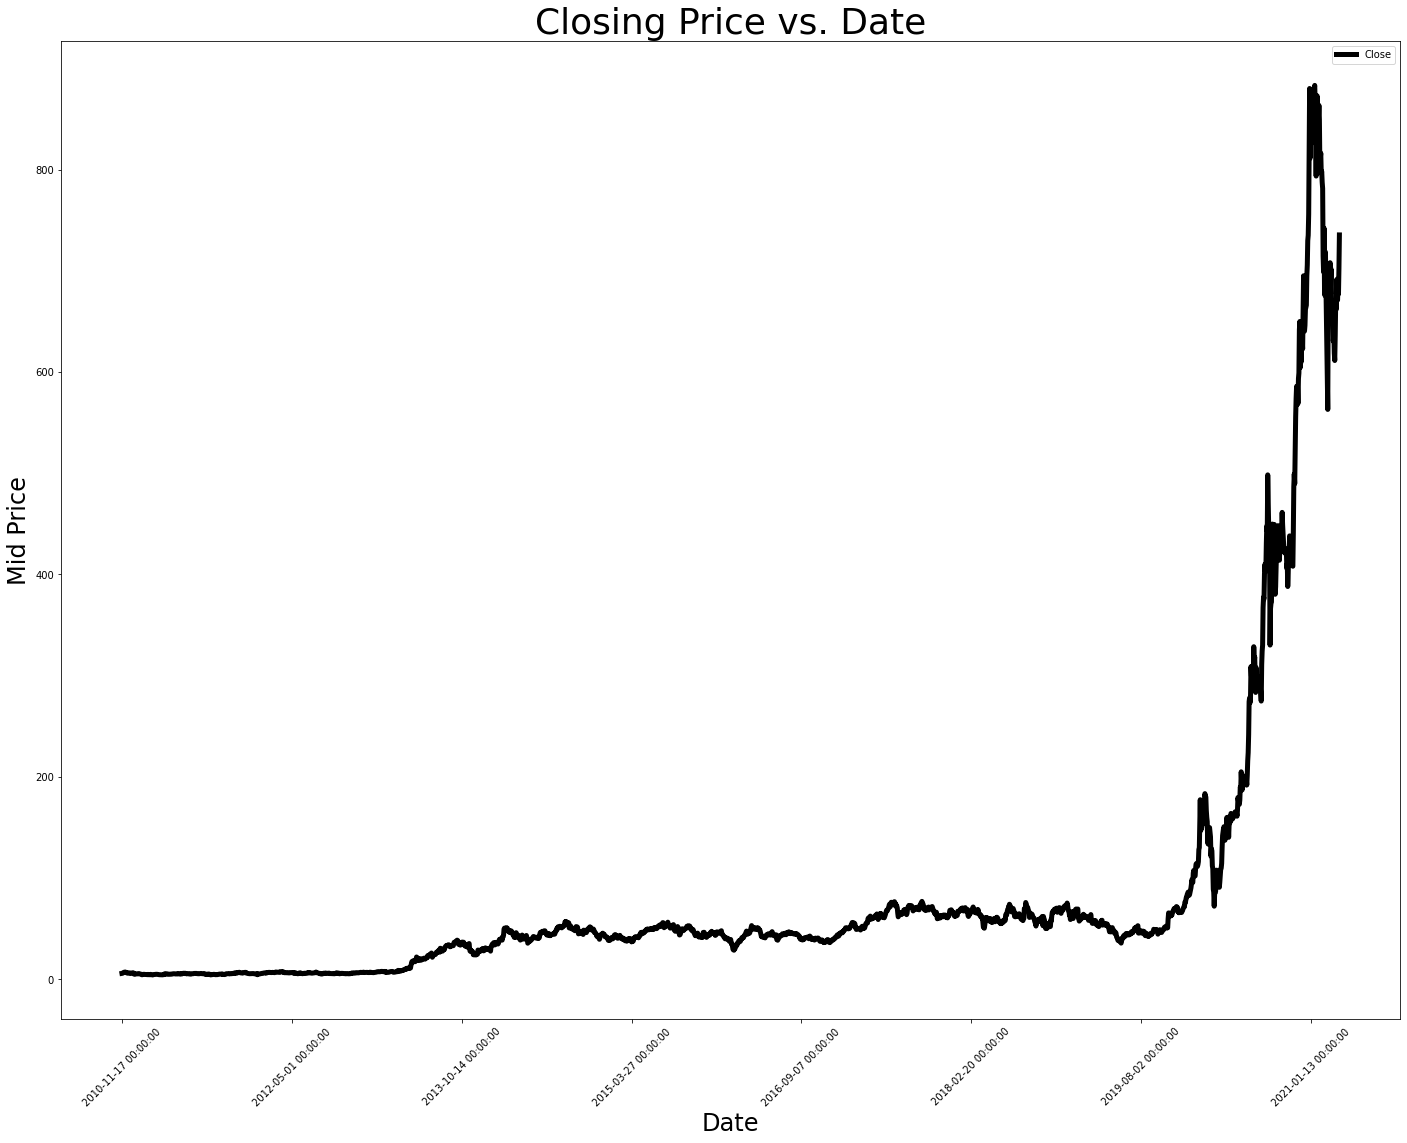

In [ ]:
fig = closing_data.get_line_plot( use_custom_df = True, df = closing_price_df, plot_features=False)
fig.show()

# Here's the next 5 day high/low prices overlaid over closing
Let's see the last 10% of data so we can see the different trends 

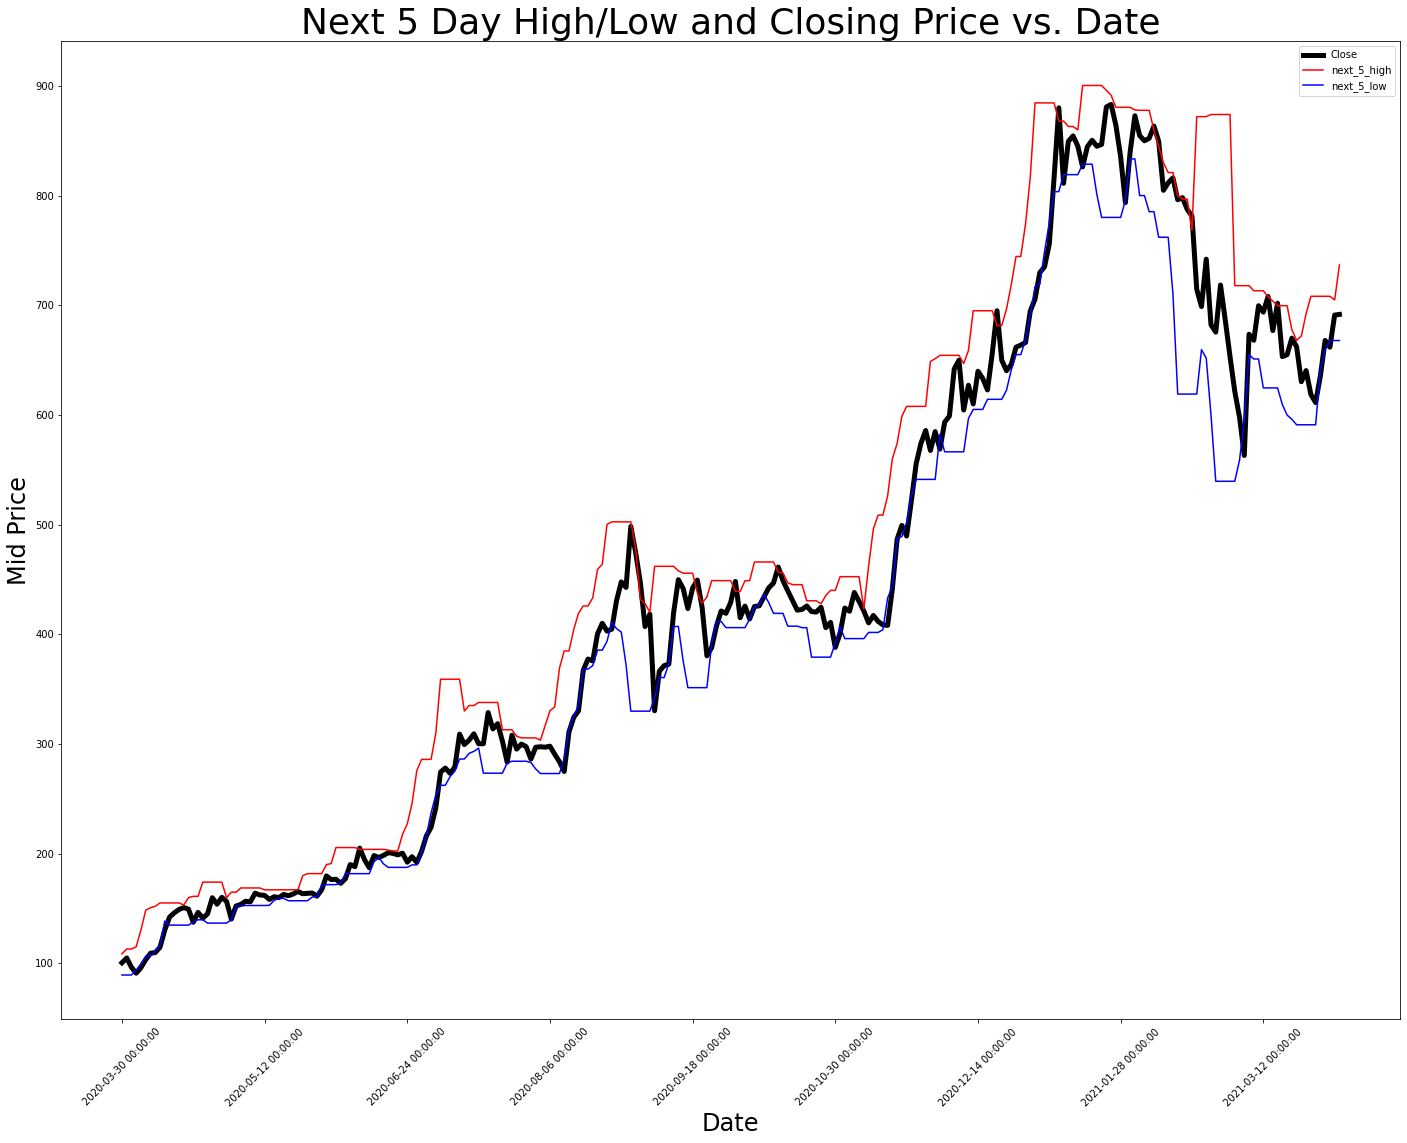

In [ ]:
dates = closing_price_df.index
start_date = dates[int(len(dates)*.9)]
end_date = dates[-1]
plot_df = five_day_high_df.join(five_day_low_df['next_5_low'])
fig = closing_data.get_next_high_low_plot(use_custom_df = True, df = plot_df.loc[start_date: end_date],  x_step=30)
fig.show()

# Technical Indicators 
Here we have plotted the 20, 50, and 100 weighted moving averages and volumed weighted average prices. Let's check out our indicators over the last 10 % of our data

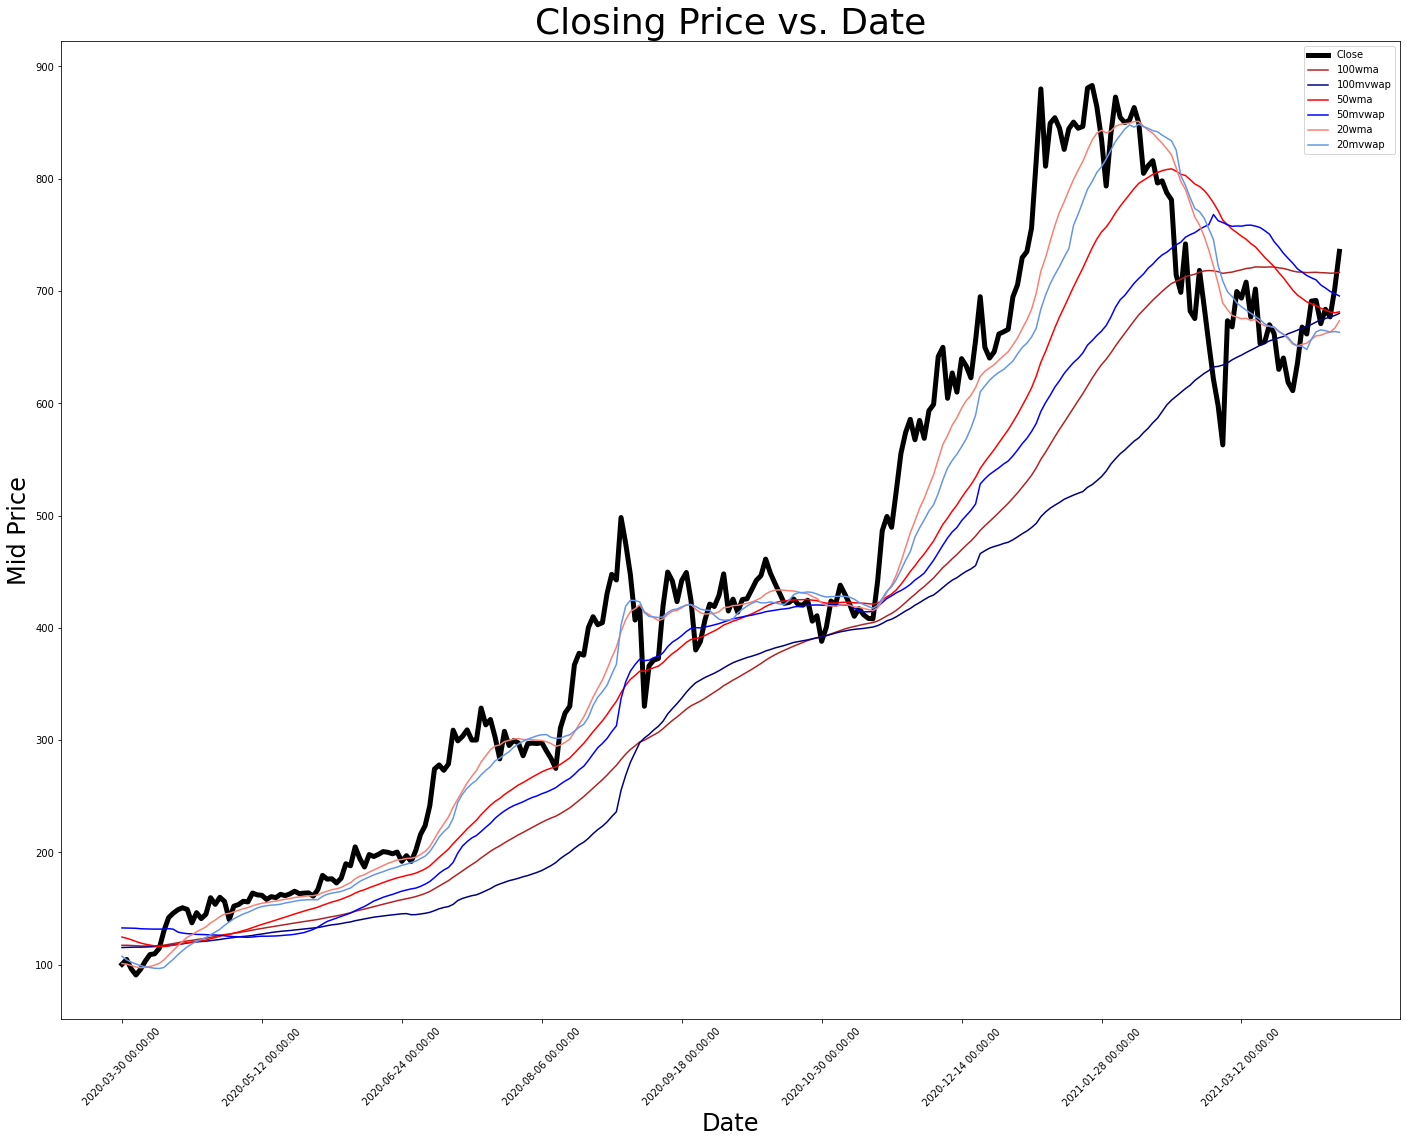

In [ ]:
fig = closing_data.get_line_plot( use_custom_df = True, df = closing_price_df.loc[start_date: end_date], plot_features=True, x_step=30)
fig.show()

# Define Model Names and Constants

In [ ]:
DIR_LOCATION = "./drive/MyDrive/enel645-team-drive/Final-Project/saved-models/"
STOCK_NAME = STOCK_NAME
CLOSING_MODEL_NAME = f'{STOCK_NAME}_CLOSING_MODEL.h5'
FIVE_DAY_HIGH_MODEL_NAME = f'{STOCK_NAME}_FIVE_DAY_HIGH_MODEL.h5'
FIVE_DAY_LOW_MODEL_NAME = f'{STOCK_NAME}_FIVE_DAY_LOW_MODEL.h5'

# Define callbacks

In [ ]:
from google.colab import drive
import tensorflow as tf
drive.mount('/content/drive')

import datetime
import os


early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience = 10)

closing_monitor = tf.keras.callbacks.ModelCheckpoint(DIR_LOCATION + CLOSING_MODEL_NAME, 
                                             monitor='loss',
                                             verbose=1,
                                             save_best_only=True,
                                             save_weights_only=True,
                                             mode='min')

five_high_closing_monitor = tf.keras.callbacks.ModelCheckpoint(DIR_LOCATION + FIVE_DAY_HIGH_MODEL_NAME, 
                                             monitor='loss',
                                             verbose=1,
                                             save_best_only=True,
                                             save_weights_only=True,
                                             mode='min')

five_low_closing_monitor = tf.keras.callbacks.ModelCheckpoint(DIR_LOCATION + FIVE_DAY_LOW_MODEL_NAME, 
                                             monitor='loss',
                                             verbose=1,
                                             save_best_only=True,
                                             save_weights_only=True,
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%10 == 0 and epoch!=0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = DIR_LOCATION,
                                                      histogram_freq=1,
                                                      write_graph=True,
                                                      write_images=False, 
                                                      update_freq='epoch')

closing_callbacks = [early_stop, closing_monitor, lr_schedule]

five_high_callbacks = [early_stop, closing_monitor, lr_schedule]

five_low_callbacks = [early_stop, closing_monitor, lr_schedule]


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Define Model Architectures

In [ ]:
import tensorflow as tf
## TODO: Make sure this is best performing model 
def model(batch_size = 1, ishape = (100,5), lr = 1e-2):
  model_input = tf.keras.layers.Input(shape = ishape, batch_size = 1)
  l3 = tf.keras.layers.LSTM(units = 20, return_sequences = True, return_state = True, stateful=True)(model_input)  #Use False for only 1 dim return, True = full sequence of hidden states
  l4 = tf.keras.layers.LSTM(units = 20, return_sequences = False)(l3)  #Use False for only 1 dim return, True = full sequence of hidden states
  output = tf.keras.layers.Dense(1, activation = 'linear')(l4)
  model = tf.keras.Model(inputs = model_input, outputs = output)
  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = lr), 
                loss = tf.keras.losses.mean_squared_error) 
  return model


#ishape should be (timesteps, n_features)
BATCH_SIZE = 1
closing_model = model(batch_size = BATCH_SIZE, ishape=(100, closing_price_df.shape[1]))
# 15 features in these models (next high )
five_day_high_model = model(batch_size = BATCH_SIZE, ishape=(100, five_day_high_df.shape[1]))
five_day_low_model = model(batch_size = BATCH_SIZE, ishape=(100, five_day_low_df.shape[1]))


# Get custom time series data generators
Note: These generators were developed to provide windowed normalization. For the next 5 day high/low, the last 5 values are copied from the last valid data to avoid information from future steps being passed into training. (ie., 94th value is copied into 95-100th values for feautres generated with future data)

In [ ]:
# How about windowed normalization? We got you covered! Here we will use a min max scaler, but you can also use a standard scaler by passing min_max_scaler=False
train_scaled_closing_data, test_scaled_closing_data = StockData.get_timeseries_generators(df=closing_price_df,
                                                                            test_percentage = 0.3, 
                                                                            target_col='c',
                                                                            length=100,
                                                                            windowed_norm=True,
                                                                            min_max_scaler=True,
                                                                            batch_size=1, 
                                                                            target_idx = 3)


train_scaled_five_day_high, test_scaled_five_day_high = StockData.get_timeseries_generators(df=five_day_high_df,
                                                                            test_percentage = 0.3, 
                                                                            target_col='next_5_high',
                                                                            length=100,
                                                                            windowed_norm=True,
                                                                            min_max_scaler=True,
                                                                            batch_size=1, 
                                                                            mask = True, 
                                                                            mask_idx = 5, 
                                                                            target_idx = 3)

train_scaled_five_day_low, test_scaled_five_day_low = StockData.get_timeseries_generators(df=five_day_low_df,
                                                                            test_percentage = 0.3, 
                                                                            target_col='next_5_low',   
                                                                            length=100,
                                                                            windowed_norm=True,
                                                                            min_max_scaler=True,
                                                                            batch_size=1, 
                                                                            mask = True, 
                                                                            mask_idx = 5, 
                                                                            target_idx = 3 )

# Prepare Trainers



In [ ]:
# Arnold schwarzenegger likes to train
arnold_closing = Trainer(None, closing_model, CLOSING_MODEL_NAME, train_scaled_closing_data, test_scaled_closing_data)
arnold_next_high = Trainer(None, five_day_high_model, FIVE_DAY_HIGH_MODEL_NAME, train_scaled_five_day_high, test_scaled_five_day_high)
arnold_next_low = Trainer(None, five_day_low_model, FIVE_DAY_LOW_MODEL_NAME, train_scaled_five_day_low, test_scaled_five_day_low)

# Training Model - Tomorrow's Closing Price

In [ ]:
arnold_closing.train_model(1000, True, callbacks=closing_callbacks)

TRAINING
Epoch 1/1000

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.
1731/1731 [==============================] - 65s 36ms/step - loss: 0.1456

Epoch 00001: loss improved from inf to 0.13912, saving model to ./drive/MyDrive/enel645-team-drive/Final-Project/saved-models/TSLA_CLOSING_MODEL.h5
Epoch 2/1000

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009999999776482582.
1731/1731 [==============================] - 58s 33ms/step - loss: 0.1045

Epoch 00002: loss improved from 0.13912 to 0.09690, saving model to ./drive/MyDrive/enel645-team-drive/Final-Project/saved-models/TSLA_CLOSING_MODEL.h5
Epoch 3/1000

Epoch 00003: LearningRateScheduler reducing learning rate to 0.009999999776482582.
1731/1731 [==============================] - 58s 34ms/step - loss: 0.1070

Epoch 00003: loss did not improve from 0.09690
Epoch 4/1000

Epoch 00004: LearningRateScheduler reducing learning rate to 0.009999999776482582.
1731/1731 [====================

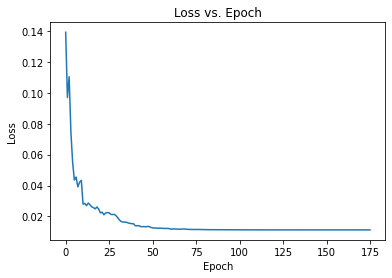

In [ ]:
fig = arnold_closing.graph_loss()

# Training Model - Next 5 Day High Price

In [ ]:
arnold_next_high.train_model(1000, True, callbacks=five_high_callbacks)

TRAINING
Epoch 1/1000

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.
1728/1728 [==============================] - 64s 35ms/step - loss: 0.1593

Epoch 00001: loss did not improve from 0.01131
Epoch 2/1000

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009999999776482582.
1728/1728 [==============================] - 57s 33ms/step - loss: 0.0835

Epoch 00002: loss did not improve from 0.01131
Epoch 3/1000

Epoch 00003: LearningRateScheduler reducing learning rate to 0.009999999776482582.
1728/1728 [==============================] - 58s 33ms/step - loss: 0.1084

Epoch 00003: loss did not improve from 0.01131
Epoch 4/1000

Epoch 00004: LearningRateScheduler reducing learning rate to 0.009999999776482582.
1728/1728 [==============================] - 59s 34ms/step - loss: 0.0653

Epoch 00004: loss did not improve from 0.01131
Epoch 5/1000

Epoch 00005: LearningRateScheduler reducing learning rate to 0.009999999776482582.
1728/1728 [=======

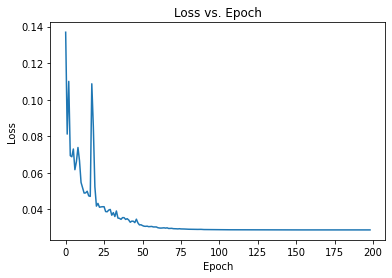

In [ ]:
fig = arnold_next_high.graph_loss()

# Training Model - Next 5 Day Low Price

In [ ]:
arnold_next_low.train_model(1000, True, callbacks=five_low_callbacks)

TRAINING
Epoch 1/1000

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.
1728/1728 [==============================] - 67s 37ms/step - loss: 0.1755

Epoch 00001: loss did not improve from 0.01131
Epoch 2/1000

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009999999776482582.
1728/1728 [==============================] - 63s 36ms/step - loss: 0.1423

Epoch 00002: loss did not improve from 0.01131
Epoch 3/1000

Epoch 00003: LearningRateScheduler reducing learning rate to 0.009999999776482582.
1728/1728 [==============================] - 64s 37ms/step - loss: 0.0882

Epoch 00003: loss did not improve from 0.01131
Epoch 4/1000

Epoch 00004: LearningRateScheduler reducing learning rate to 0.009999999776482582.
1728/1728 [==============================] - 62s 36ms/step - loss: 0.1195

Epoch 00004: loss did not improve from 0.01131
Epoch 5/1000

Epoch 00005: LearningRateScheduler reducing learning rate to 0.009999999776482582.
1728/1728 [=======

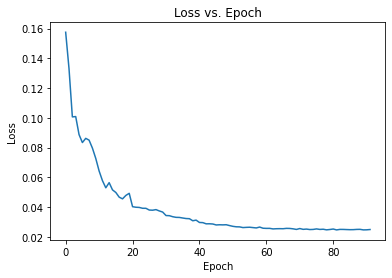

In [ ]:
fig = arnold_next_low.graph_loss()

# Results - Tomorrow's Closing Price

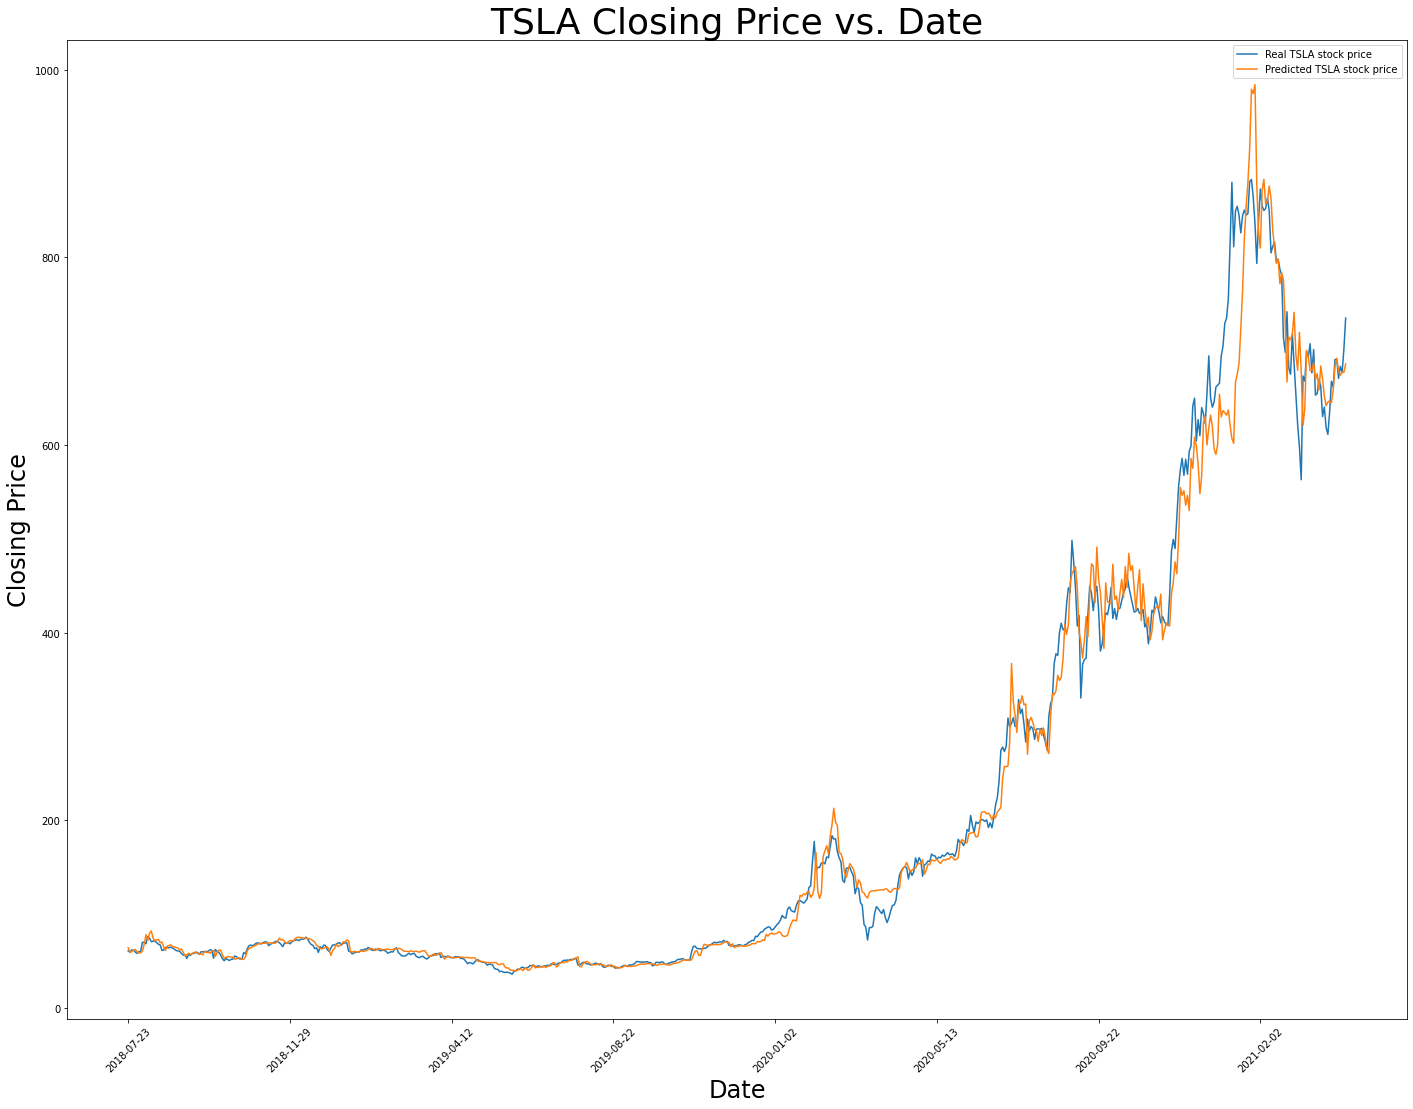

In [ ]:
from deeptendies.result_plots import ModelResultPlots
def get_results(df, train_data_gen, model, title = "Closing Price vs. Date", predicted_value_name = "stock price"): 
  train_idx, test_idx= StockData.get_train_test_split(df)
  days = [str(x).split("T")[0] for x in df.index[train_idx+train_data_gen.length:].values]
  predictions = model.get_predictions()
  y_true = predictions['actual']
  y_predicted = predictions['predicted']
  fig = ModelResultPlots.plot_predicted_vs_original_price(y_true, y_predicted, STOCK_NAME, days, x_step=91)
  return fig, y_true, y_predicted


fig, y_true, y_predicted = get_results(closing_price_df, train_scaled_closing_data, arnold_closing)
fig.show()

In [ ]:
import numpy as np 
metrics = ModelMetrics(y_true = np.array(y_true), y_predicted=np.array(y_predicted))
print(f'{CLOSING_MODEL_NAME} achieved the folowing results:')
metrics.print_metrics()

TSLA_CLOSING_MODEL.h5 achieved the folowing results:
Mean squared error:		 884.6977486794074
Root mean squared error:	 29.743869093973085
Mean absolute error:		 13.936090027691808
Mean absolute percentage error:	 0.061747921818204085
Mean percentage error:		 -0.005559784065796187
Mean directional accuracy:	 0.5080291970802919


# Results - Next 5 Day High Price

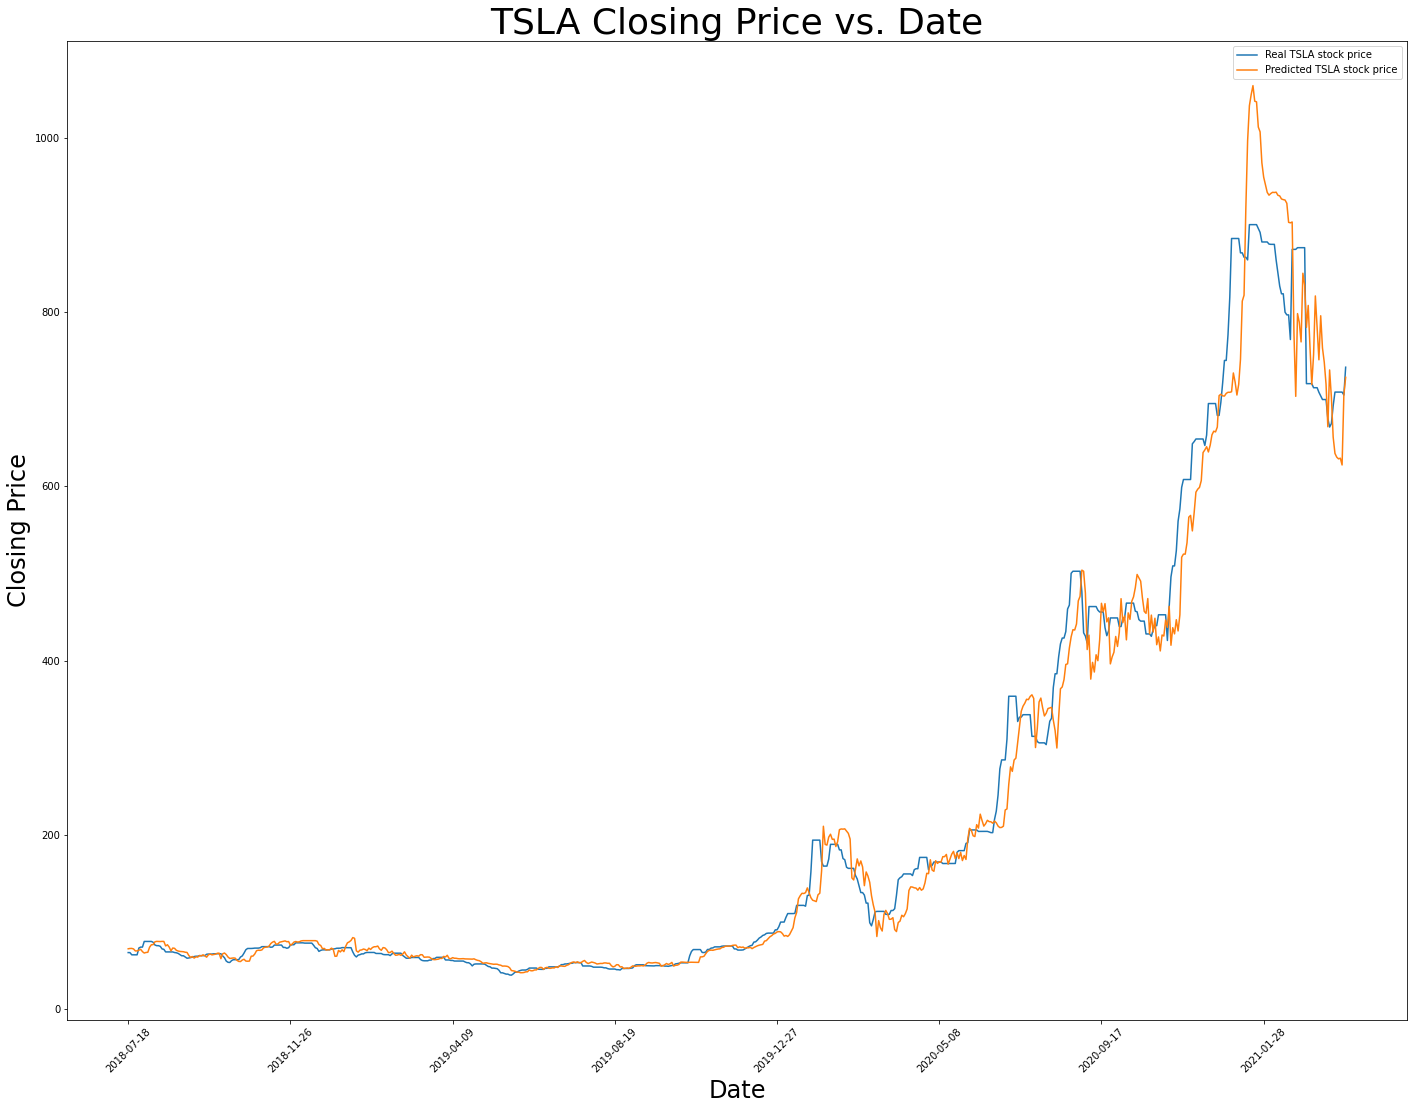

In [ ]:
fig, y_true, y_predicted = get_results(five_day_high_df, train_scaled_five_day_high, arnold_next_high, title = "Next Five Day High Price vs. Date", predicted_value_name = "5 day high price")
fig.show()

In [ ]:
import numpy as np 
metrics = ModelMetrics(y_true = np.array(y_true), y_predicted=np.array(y_predicted))
print(f'{FIVE_DAY_HIGH_MODEL_NAME} achieved the folowing results:')
metrics.print_metrics()

TSLA_FIVE_DAY_HIGH_MODEL.h5 achieved the folowing results:
Mean squared error:		 1510.060003263384
Root mean squared error:	 38.85949051729042
Mean absolute error:		 21.575543901542083
Mean absolute percentage error:	 0.08379748055501922
Mean percentage error:		 -7.789591033881117e-05
Mean directional accuracy:	 0.3191800878477306


# Results - Next 5 Day Low Price

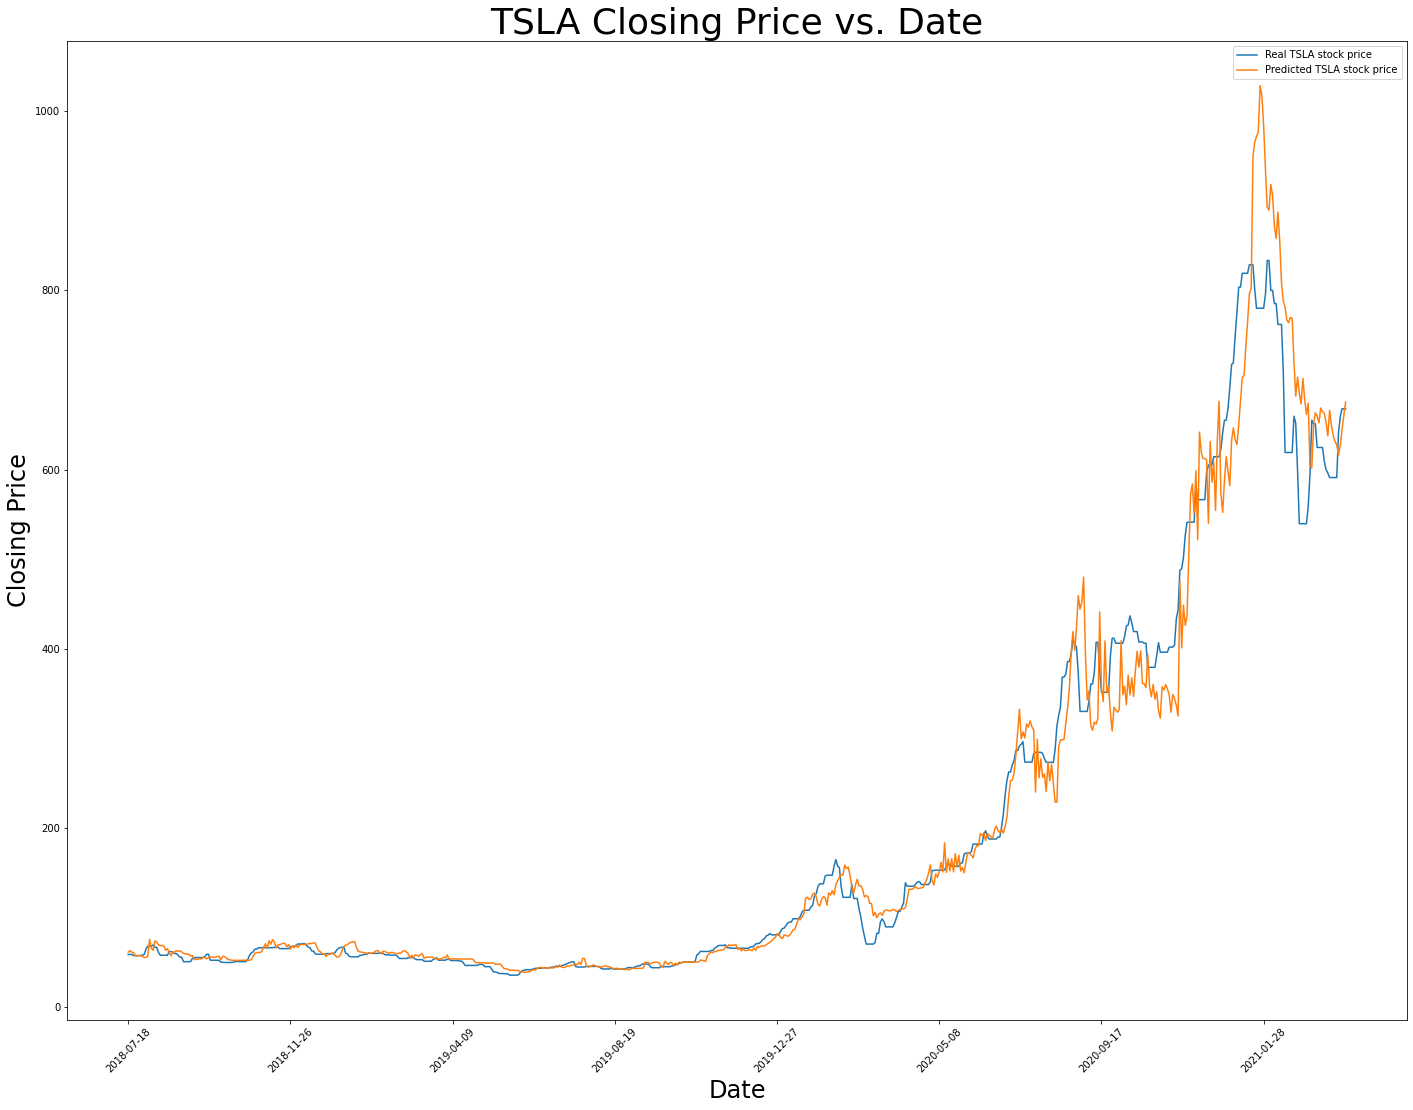

In [ ]:
fig, y_true, y_predicted = get_results(five_day_low_df, train_scaled_five_day_low, arnold_next_low, title = "Next Five Day Low Price vs. Date", predicted_value_name = "5 day low price")
fig.show()

In [ ]:
import numpy as np 
metrics = ModelMetrics(y_true = np.array(y_true), y_predicted=np.array(y_predicted))
print(f'{FIVE_DAY_LOW_MODEL_NAME} achieved the folowing results:')
metrics.print_metrics()

TSLA_FIVE_DAY_LOW_MODEL.h5 achieved the folowing results:
Mean squared error:		 1767.3893306702128
Root mean squared error:	 42.040329811625085
Mean absolute error:		 21.735705915197187
Mean absolute percentage error:	 0.09417178586324353
Mean percentage error:		 -0.023615505235369493
Mean directional accuracy:	 0.2796486090775988
